In [5]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import sys
sys.path.append("../../modules/")
import helper as hp
import matplotlib.pyplot as plt
%matplotlib inline
import draw_net
from IPython.display import Image
import numpy as np
reload(draw_net)
from skimage import io
import cPickle as pickle
import os
from time import time

In [4]:
?draw_net.get_pydot_graph

In [2]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/dr-data/train-trim-ben-r400-512/"

In [3]:
with open("dr.pkl") as f:
    dat = pickle.load(f)
X_left, X_right, y = dat
X_left = np.asarray(X_left)
X_right = np.asarray(X_right)
y = np.asarray(y, dtype="int32")

In [4]:
np.random.seed(0)

In [5]:
idxs = [x for x in range(0, len(X_left))]
np.random.shuffle(idxs)

In [6]:
X_train_left = X_left[idxs][0 : int(0.9*X_left.shape[0])]
X_train_right = X_right[idxs][0 : int(0.9*X_right.shape[0])]
y_train = y[idxs][0 : int(0.9*y.shape[0])]

X_valid_left = X_left[idxs][int(0.9*X_left.shape[0]) ::]
X_valid_right = X_right[idxs][int(0.9*X_right.shape[0]) ::]
y_valid = y[idxs][int(0.9*y.shape[0]) ::]

-----

In [6]:
def get_net(net_fn, args={}):
    # ----
    X_left = T.tensor4('X_left')
    X_right = T.tensor4('X_right')
    y = T.ivector('y')
    # ----
    
    cfg = net_fn(args)
    l_out = cfg["l_out"]
    l_in_left = cfg["l_in_left"]
    l_in_right = cfg["l_in_right"]
    
    net_out = get_output(l_out, {l_in_left: X_left, l_in_right: X_right})
    net_out_det = get_output(l_out, {l_in_left: X_left, l_in_right: X_right}, deterministic=True)
    
    if not args["kappa_loss"]:
        loss = categorical_crossentropy(net_out, y).mean()
        loss_det = categorical_crossentropy(net_out_det, y).mean()
    else:
        loss = get_kappa_loss(5)(net_out, y).mean()
        loss_det = get_kappa_loss(5)(net_out_det, y).mean()
    
    if "l2" in args:
        sys.stderr.write("adding l2: %f\n" % args["l2"])
        loss += args["l2"]*regularize_layer_params(l_out, l2)
        loss_det += args["l2"]*regularize_layer_params(l_out, l2)
    params = get_all_params(l_out, trainable=True)
    if "max_norm" in args:
        grads = total_norm_constraint( T.grad(loss, params), max_norm=args["max_norm"])
    else:
        grads = T.grad(loss, params)
    learning_rate = theano.shared(floatX(0.01)) if "learning_rate" not in args else theano.shared(floatX(args["learning_rate"]))
    momentum = 0.9 if "momentum" not in args else args["momentum"]
    if "rmsprop" in args:
        sys.stderr.write("using rmsprop instead of nesterov momentum...\n")
        updates = rmsprop(grads, params, learning_rate=learning_rate)
    else:
        updates = nesterov_momentum(grads, params, learning_rate=learning_rate, momentum=momentum)
    # index fns
    bs = args["batch_size"]
    train_fn = theano.function(inputs=[X_left,X_right,y], outputs=loss, updates=updates)
    loss_fn = theano.function(inputs=[X_left,X_right,y], outputs=loss_det)
    preds_fn = theano.function(inputs=[X_left,X_right], outputs=T.argmax(net_out_det,axis=1))
    
    return {
        "train_fn": train_fn,
        "loss_fn": loss_fn,
        "preds_fn": preds_fn,
        "l_out": l_out,
        "learning_rate": learning_rate,
        "bs": bs
    }


In [12]:

def net(args={}):
    l_in_left = InputLayer( (None, 3, 512, 512) )
    l_in_right = InputLayer( (None, 3, 512, 512) )
    # left image
    l_topleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 )
    # right image
    l_topleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(0,256), axis=3 )
    l_bottomleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(0,256), axis=3 )
    l_topright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,256), axis=2), indices=slice(256,512), axis=3 )
    l_bottomright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(256,512), axis=2), indices=slice(256,512), axis=3 ) 
    
    def net_block(quadrant, dd):
        #l_in = InputLayer(
        #    shape=(None, 3, 256, 256),
        #)
        # { "type": "CONV", "num_filters": 32, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        l_conv1 = Conv2DLayer(
            quadrant,
            num_filters=32,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv1" not in dd else dd["l_conv1"].W,
            b=Constant(0.) if "l_conv1" not in dd else dd["l_conv1"].b
        )
        l_pool1 = MaxPool2DLayer(
            l_conv1,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 64, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" }
        l_dropout1 = DropoutLayer(l_pool1, p=0.1)
        l_conv2 = Conv2DLayer(
            l_dropout1,
            num_filters=64,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv2" not in dd else dd["l_conv2"].W,
            b=Constant(0.) if "l_conv2" not in dd else dd["l_conv2"].b
        )
        l_pool2 = MaxPool2DLayer(
            l_conv2,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "nonlinearity": "LReLU" },
        l_dropout2 = DropoutLayer(l_pool2, p=0.1)
        l_conv3 = Conv2DLayer(
            l_dropout2,
            num_filters=128,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv3" not in dd else dd["l_conv3"].W,
            b=Constant(0.) if "l_conv3" not in dd else dd["l_conv3"].b
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        l_dropout3 = DropoutLayer(l_conv3, p=0.1)
        l_conv4 = Conv2DLayer(
            l_dropout3,
            num_filters=128,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv4" not in dd else dd["l_conv4"].W,
            b=Constant(0.) if "l_conv4" not in dd else dd["l_conv4"].b
        )
        l_pool3 = MaxPool2DLayer(
            l_conv4,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 128, "filter_size": 3, "pool_size": 3, "pool_stride": 2, "nonlinearity": "LReLU" },
        l_dropout4 = DropoutLayer(l_pool3, p=0.1)
        l_conv5 = Conv2DLayer(
            l_dropout4,
            num_filters=128,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv5" not in dd else dd["l_conv5"].W,
            b=Constant(0.) if "l_conv5" not in dd else dd["l_conv5"].b
        )
        # maxpool size 3 stride 2
        l_pool4 = MaxPool2DLayer(
            l_conv5,
            pool_size=(3,3),
            stride=2
        )
        # { "type": "CONV", "dropout": 0.1, "num_filters": 256, "filter_size": 3, "pool_size": 2, "pool_stride": 2, "nonlinearity": "LReLU" },
        l_dropout5 = DropoutLayer(l_pool4, p=0.1)
        l_conv6 = Conv2DLayer(
            l_dropout5,
            num_filters=256,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv6" not in dd else dd["l_conv6"].W,
            b=Constant(0.) if "l_conv6" not in dd else dd["l_conv6"].b
        )
        l_pool5 = MaxPool2DLayer(
            l_conv6,
            pool_size=(2,2),
            stride=2
        )
        
        l_dropout5a = DropoutLayer(l_pool5, p=0.1)
        l_conv7 = Conv2DLayer(
            l_dropout5a,
            num_filters=512,
            filter_size=(3,3),
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_conv6" not in dd else dd["l_conv6"].W,
            b=Constant(0.) if "l_conv6" not in dd else dd["l_conv6"].b
        )        

        # { "type": "FC", "dropout": 0.5, "num_units": 2048, "pool_size": 2, "nonlinearity": "LReLU" },
        l_dropout6 = lasagne.layers.DropoutLayer(l_conv7, p=0.5)
        l_hidden1 = lasagne.layers.DenseLayer(
            l_dropout6,
            num_units=512,
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_hidden1" not in dd else dd["l_hidden1"].W,
            b=Constant(0.) if "l_hidden1" not in dd else dd["l_hidden1"].b
        )

        #l_pool6 = lasagne.layers.FeaturePoolLayer(
        #    l_hidden1,
        #    pool_size=2
        #)
        
        # { "type": "FC", "dropout": 0.5, "num_units": 2048, "pool_size": 2, "nonlinearity": "LReLU" },
        l_dropout7 = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)
        l_hidden2 = lasagne.layers.DenseLayer(
            l_dropout7,
            num_units=512,
            nonlinearity=leaky_rectify,
            W=GlorotUniform(gain="relu") if "l_hidden2" not in dd else dd["l_hidden2"].W,
            b=Constant(0.) if "l_hidden2" not in dd else dd["l_hidden2"].b
        )
        
        #l_pool7 = lasagne.layers.FeaturePoolLayer(
        #    l_hidden2,
        #    pool_size=2
        #)
        
        # { "type": "OUTPUT", "dropout": 0.5, "nonlinearity": "sigmoid" }
        #l_dropout8 = lasagne.layers.DropoutLayer(l_pool7, p=0.5)
        #l_out = lasagne.layers.DenseLayer(
        #    l_dropout8,
        #    num_units=5,
        #    nonlinearity=softmax,
        #    W=GlorotUniform()
        #)
        #return l_out

        #l_out = l_pool7
        l_out = l_hidden2

        return {
            "l_conv1": l_conv1,
            "l_conv2": l_conv2,
            "l_conv3": l_conv3,
            "l_conv4": l_conv4,
            "l_conv5": l_conv5,
            "l_hidden1": l_hidden1,
            "l_hidden2": l_hidden2,
            "l_out": l_out
        }

    topleft_conv_left = net_block(l_topleft_left, {})
    bottomleft_conv_left = net_block(l_bottomleft_left, topleft_conv_left)
    topright_conv_left = net_block(l_topright_left, topleft_conv_left)
    bottomright_conv_left = net_block(l_bottomright_left, topleft_conv_left)

    topleft_conv_right = net_block(l_topleft_right, topleft_conv_left)
    bottomleft_conv_right = net_block(l_bottomleft_right, topleft_conv_left)
    topright_conv_right = net_block(l_topright_right, topleft_conv_left)
    bottomright_conv_right = net_block(l_bottomright_right, topleft_conv_left)
    
    l_concat_left = ConcatLayer([
        topleft_conv_left["l_out"], 
        bottomleft_conv_left["l_out"], 
        topright_conv_left["l_out"], 
        bottomright_conv_left["l_out"],   
    ])

    l_concat_right = ConcatLayer([
        topleft_conv_right["l_out"], 
        bottomleft_conv_right["l_out"], 
        topright_conv_right["l_out"], 
        bottomright_conv_right["l_out"],   
    ])

    l_merge = ElemwiseSumLayer(
        [l_concat_left, l_concat_right]
    )
    
    l_dropout = DropoutLayer(l_merge, p=0.5)

    l_out = lasagne.layers.DenseLayer(
        l_dropout,
        num_units=5,
        nonlinearity=softmax,
        W=GlorotUniform()
    )

    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    
    return {"l_out": l_out, "l_in_left": l_in_left, "l_in_right": l_in_right}



In [7]:
def iterate(X_arr_left, X_arr_right, y_arr, bs, augment):
    assert X_arr_left.shape[0] == X_arr_right.shape[0] == y_arr.shape[0]
    b = 0
    DATA_DIR = os.environ["DATA_DIR"]
    while True:
        if b*bs >= X_arr_left.shape[0]:
            break
        this_X_left, this_X_right, this_y = \
            X_arr_left[b*bs:(b+1)*bs], X_arr_right[b*bs:(b+1)*bs], y_arr[b*bs:(b+1)*bs]
        # load the images
        images_for_this_X_left = \
            [ hp.load_image("%s/%s.jpeg" % (DATA_DIR,filename), augment=augment) for filename in this_X_left ]
        images_for_this_X_left = np.asarray(images_for_this_X_left, dtype="float32")
        
        images_for_this_X_right = \
            [ hp.load_image("%s/%s.jpeg" % (DATA_DIR,filename), augment=augment) for filename in this_X_right ]
        images_for_this_X_right = np.asarray(images_for_this_X_right, dtype="float32")
        
        print images_for_this_X_left.shape
        print images_for_this_X_right.shape
        print this_y.shape

        yield images_for_this_X_left, images_for_this_X_right, this_y
        
        # ---
        b += 1


In [8]:
def train(net_cfg, 
          num_epochs,
          data,
          out_file=None,
          print_out=True,
          debug=False,
          resume=None,
          schedule={}):
    # prepare the out_file
    l_out = net_cfg["l_out"]
    f = None
    if resume == None:
        if out_file != None:
            f = open("%s.txt" % out_file, "wb")
            f.write("epoch,train_loss,avg_valid_loss,valid_accuracy,time\n")
        if print_out:
            print "epoch,train_loss,avg_valid_loss,valid_accuracy,time"
    else:
        sys.stderr.write("resuming training...\n")
        if out_file != None:
            f = open("%s.txt" % out_file, "ab")
        with open(resume) as g:
            set_all_param_values(l_out, pickle.load(g))          
    
    # extract functions
    X_train_left, X_train_right, y_train, X_valid_left, X_valid_right, y_valid = data
    train_fn, loss_fn, preds_fn = net_cfg["train_fn"], net_cfg["loss_fn"], net_cfg["preds_fn"]
    learning_rate = net_cfg["learning_rate"]
    bs = net_cfg["bs"]
    
    # training
    train_idxs = [x for x in range(0, X_train_left.shape[0])]
    
    if debug:
        sys.stderr.write("idxs: %s\n" % train_idxs)
    for epoch in range(0, num_epochs):
        
        if epoch+1 in schedule:
            sys.stderr.write("changing learning rate to: %f" % schedule[epoch+1])
            learning_rate.set_value( floatX(schedule[epoch+1]) )
        
        np.random.shuffle(train_idxs)
        X_train_left, X_train_right = X_train_left[train_idxs], X_train_right[train_idxs]
        y_train = y_train[train_idxs]
        
        # training loop
        this_train_losses = []
        t0 = time()
        for X_train_batch_left, X_train_batch_right, y_train_batch in iterate(X_train_left, X_train_right, y_train, bs, True):
            this_train_losses.append( train_fn(X_train_batch_left, X_train_batch_right, y_train_batch) )
        time_taken = time() - t0
        
        # validation loss loop
        this_valid_losses = []
        for X_valid_batch_left, X_valid_batch_right, y_valid_batch in iterate(X_valid_left, X_valid_right, y_valid, bs, False):
            this_valid_losses.append( loss_fn(X_valid_batch_left, X_valid_batch_right, y_valid_batch) )
        avg_valid_loss = np.mean(this_valid_losses)
        
        # validation accuracy loop
        this_valid_preds = []
        for X_valid_batch_left, X_valid_batch_right, _ in iterate(X_valid_left, X_valid_right, y_valid, bs, False):
            this_valid_preds += preds_fn(X_valid_batch_left, X_valid_batch_right).tolist()
        valid_acc = np.mean( this_valid_preds == y_valid )
        
        # validation set kappa
        valid_kappa = hp.weighted_kappa(human_rater=this_valid_preds, actual_rater=y_valid, num_classes=5)
        
        ## ------------ ##
        if f != None:
            f.write(
                "%i,%f,%f,%f,%f,%f\n" %
                    (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, valid_kappa, time_taken) 
            )
            f.flush()
        if print_out:
            print "%i,%f,%f,%f,%f,%f" % \
                (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, valid_kappa, time_taken)
            
        with open("models/%s.model.%i" % (os.path.basename(out_file),epoch+1), "wb") as g:
            pickle.dump(get_all_param_values(l_out), g, pickle.HIGHEST_PROTOCOL) 
            
    if f != None:
        f.close()

number of params: 14823749


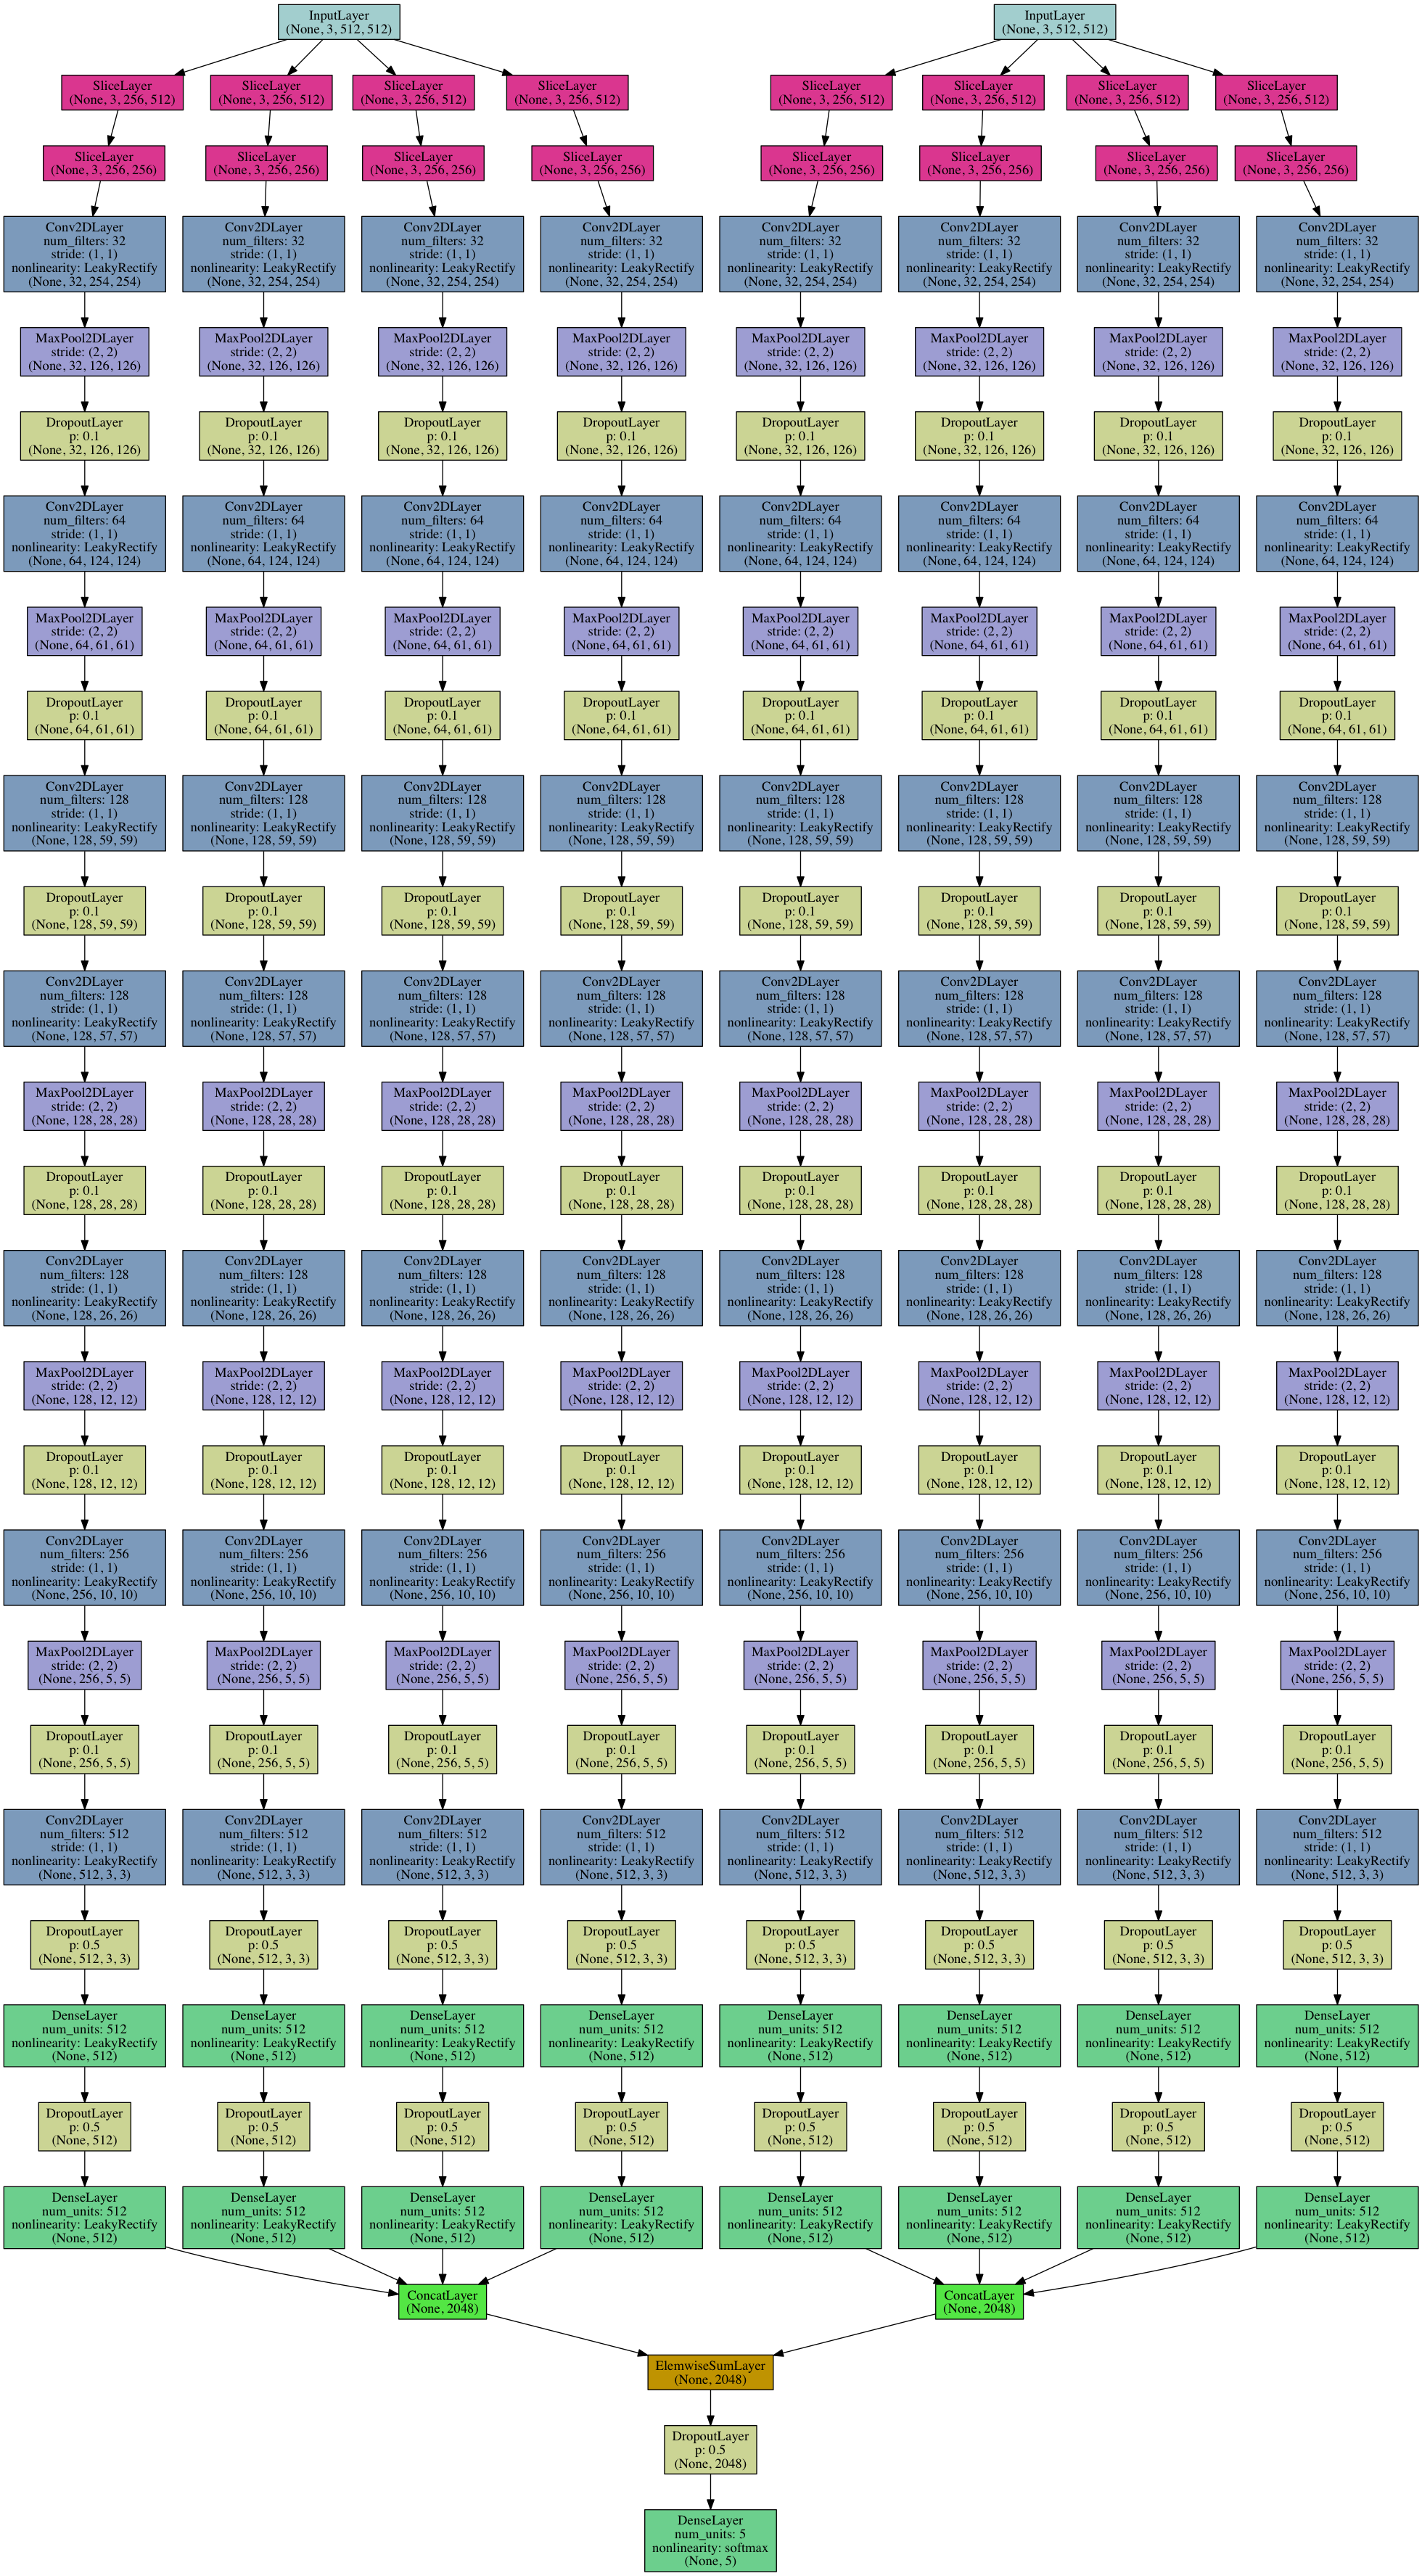

In [13]:
draw_net.draw_to_notebook(get_all_layers(net()["l_out"]), verbose=True)

In [ ]:
draw_net.

In [30]:
DropoutLayer( InputLayer((None, 1, 28, 28) ), p=0.5).p

0.5

In [46]:
for layer in get_all_layers(l_out):
    print layer, layer.output_shape
print count_params(l_out)

<lasagne.layers.input.InputLayer object at 0x10a79cd50> (None, 1, 512, 512)
<lasagne.layers.shape.SliceLayer object at 0x128b2ee50> (None, 1, 256, 512)
<lasagne.layers.shape.SliceLayer object at 0x128b2ef50> (None, 1, 256, 256)
<lasagne.layers.conv.Conv2DLayer object at 0x10a771850> (None, 32, 254, 254)
<lasagne.layers.pool.MaxPool2DLayer object at 0x128b34910> (None, 32, 126, 126)
<lasagne.layers.noise.DropoutLayer object at 0x10a771190> (None, 32, 126, 126)
<lasagne.layers.conv.Conv2DLayer object at 0x10a281810> (None, 64, 124, 124)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10a218410> (None, 64, 61, 61)
<lasagne.layers.noise.DropoutLayer object at 0x10a281710> (None, 64, 61, 61)
<lasagne.layers.conv.Conv2DLayer object at 0x128b2e090> (None, 128, 59, 59)
<lasagne.layers.noise.DropoutLayer object at 0x103c5ee50> (None, 128, 59, 59)
<lasagne.layers.conv.Conv2DLayer object at 0x128b2e710> (None, 128, 57, 57)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10a771610> (None, 128, 28,

In [21]:
tmp_net = get_net(net, {"kappa_loss": False, "batch_size": 32})

In [22]:
tmp_net["bs"] = 2

In [28]:
#draw_net.draw_to_notebook(get_all_layers(tmp_net["l_out"]))

In [23]:
train(
    tmp_net, 
    num_epochs=1, 
    data=(X_train_left[0:5], X_train_right[0:5], y_train[0:5], X_valid_left[0:5], X_valid_right[0:5], y_valid[0:5])
)

epoch,train_loss,avg_valid_loss,valid_accuracy,time
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(1, 3, 512, 512)
(1, 3, 512, 512)
(1,)
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(1, 3, 512, 512)
(1, 3, 512, 512)
(1,)
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(2, 3, 512, 512)
(2, 3, 512, 512)
(2,)
(1, 3, 512, 512)
(1, 3, 512, 512)
(1,)
1,233.146844,15922.454055,0.000000,0.000000,78.765803


AttributeError: 'NoneType' object has no attribute 'rfind'

-----

In [ ]:
def train(net_cfg, 
          num_epochs,
          data,
          out_file=None,
          print_out=True,
          debug=False,
          resume=None,
          schedule={}):